##Teste de varias arquiteturas no mesmo codigo
O script:

- Carrega e divide os dados (70% treino / 15% val / 15% teste).

- Normaliza feature-a-feature usando StandardScaler ajustado só no treino.

- Define uma camada de atenção customizada (funciona dentro do grafo Keras).

- Define uma função que constrói 4 variantes de modelo (simples, empilhado, bidirecional, attention).

- Treina cada modelo (com EarlyStopping usando validação).

- Avalia cada modelo no conjunto de teste com as métricas que você pediu.

- Mostra uma matriz de confusão do melhor modelo (segundo AUC).

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, accuracy_score, average_precision_score
)
import matplotlib.pyplot as plt

# ==========================================
# 1. CARREGAR E NORMALIZAR DADOS
# ==========================================

dados = np.load("/content/sem_bal_mimic_X_y_1h.npz")
X, y = dados['X'], dados['y']
mask = dados['mask']

In [ ]:
# Split 70% treino, 15% validação, 15% teste
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}")

Treino: (35632, 10, 8), Validação: (7636, 10, 8), Teste: (7636, 10, 8)


In [ ]:
# Normalização feature a feature
scaler = StandardScaler()
n_samples, n_janelas, n_features = X_train.shape

for i in range(n_features):
    scaler.fit(X_train[:, :, i])
    X_train[:, :, i] = scaler.transform(X_train[:, :, i])
    X_val[:, :, i] = scaler.transform(X_val[:, :, i])
    X_test[:, :, i] = scaler.transform(X_test[:, :, i])

###Arquitetura de atencao hibrida

In [ ]:
# ============================================================
# 📌 Camada de Atenção customizada (funcional com KerasTensor)
# ============================================================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias",  #b significa bias
                                 shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)  #softmax da pesos
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha  #context e a soma ponderada
        context = K.sum(context, axis=1)
        return context

Quatro arquiteturas:

- Simples: LSTM retorna um vetor final (último estado).

- Empilhado: LSTM com return_sequences=True seguido de outro LSTM (captura representações hierárquicas).

- Bidirectional: LSTM roda forward+backward e concatena representações (útil para dependências longas).

- Attention: LSTM retorna sequência completa; a camada de atenção calcula context.

In [ ]:
# ============================================================
# 📌 Função para construir modelos LSTM com variações
# ============================================================
def build_lstm_model(input_shape, model_type="simples"):
    inputs = Input(shape=input_shape)

    if model_type == "simples":
        x = LSTM(64)(inputs)

    elif model_type == "empilhado":
        x = LSTM(64, return_sequences=True)(inputs)
        x = LSTM(32)(x)

    elif model_type == "bidirectional":
        x = Bidirectional(LSTM(64))(inputs)

    elif model_type == "attention":
        x = LSTM(64, return_sequences=True)(inputs)
        x = AttentionLayer()(x)

    else:
        raise ValueError("Tipo de modelo inválido.")

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# ==========================================
# 3. LOOP DE TREINAMENTO E AVALIAÇÃO
# ==========================================
model_types = ["simples", "empilhado", "bidirectional", "attention"]
results = []

for mtype in model_types:
    print(f"\n🚀 Treinando modelo: {mtype.upper()}")

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), model_type=mtype)

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=70,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Predição no teste
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Métricas detalhadas
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auprc = average_precision_score(y_test, y_pred_prob)

    print(f"📊 {mtype.upper()} -> AUC: {auc:.4f}, F1: {f1:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, AUPRC: {auprc:.4f}")

    results.append({
        'Modelo': mtype,
        'Acurácia': acc,
        'AUC': auc,
        'Precisão': prec,
        'Revocação': rec,
        'F1-score': f1,
        'AUPRC': auprc
    })


🚀 Treinando modelo: SIMPLES
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
📊 SIMPLES -> AUC: 0.7871, F1: 0.1736, Acc: 0.8654, Prec: 0.4843, Rec: 0.1058, AUPRC: 0.3740

🚀 Treinando modelo: EMPILHADO
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
📊 EMPILHADO -> AUC: 0.7861, F1: 0.1340, Acc: 0.8680, Prec: 0.5455, Rec: 0.0764, AUPRC: 0.3743

🚀 Treinando modelo: BIDIRECTIONAL
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
📊 BIDIRECTIONAL -> AUC: 0.7840, F1: 0.1012, Acc: 0.8673, Prec: 0.5377, Rec: 0.0558, AUPRC: 0.3650

🚀 Treinando modelo: ATTENTION
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
📊 ATTENTION -> AUC: 0.7863, F1: 0.1777, Acc: 0.8667, Prec: 0.5069, Rec: 0.1077, AUPRC: 0.3712



📋 Resultados comparativos finais:
          Modelo  Acurácia       AUC  Precisão  Revocação  F1-score     AUPRC
0        simples  0.865375  0.787141  0.484305   0.105779  0.173633  0.373998
1      empilhado  0.867994  0.786085  0.545455   0.076396  0.134021  0.374260
2  bidirectional  0.867339  0.784047  0.537736   0.055828  0.101154  0.364996
3      attention  0.866684  0.786328  0.506912   0.107738  0.177706  0.371233

🏆 Melhor modelo: SIMPLES
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


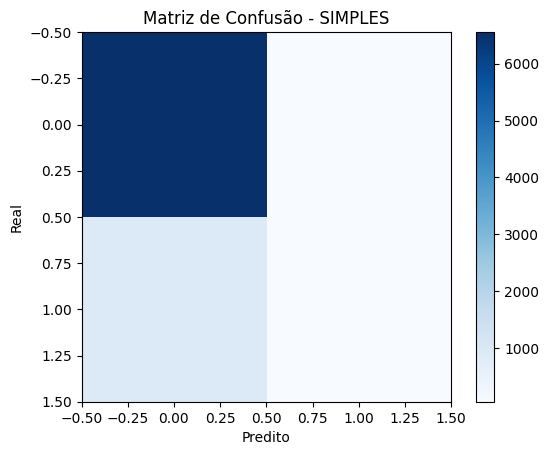

In [ ]:
# ==========================================
# 4. RESULTADOS FINAIS
# ==========================================
df_results = pd.DataFrame(results)
print("\n📋 Resultados comparativos finais:")
print(df_results)

# ==========================================
# Matriz de confusão do melhor modelo
# ==========================================
best_model_name = df_results.sort_values('AUC', ascending=False).iloc[0]['Modelo']
print(f"\n🏆 Melhor modelo: {best_model_name.upper()}")

best_model = build_lstm_model((X_train.shape[1], X_train.shape[2]), best_model_name)
best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, verbose=0
)

y_pred_prob = best_model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title(f"Matriz de Confusão - {best_model_name.upper()}")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.colorbar()
plt.show()